# Document classification

In [2]:
!pip list | grep tensorflow

tensorflow-estimator         2.7.0
tensorflow-gpu               2.7.0
tensorflow-io-gcs-filesystem 0.22.0


In [1]:
!nvidia-smi

Sat Dec 11 08:53:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   32C    P0    39W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import transformers

print(transformers.__version__)

4.12.5


In [2]:
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "sberbank-ai/ruRoberta-large"

batch_size = 8

## Dataset

In [3]:
import pandas as pd

training_columns=['path', 'text']
df = pd.read_excel(open('classifier.xlsx', 'rb'), sheet_name='good', index_col=0)
# df = pd.read_excel(open('classifier (17).xlsx', 'rb'), sheet_name='good', index_col=0)


df = df[['documentType']+training_columns]
df.head()

,documentType,path,text
0,CONTRACT,ДД по практикам\Практика коммерческой логистик...,2.1. В соответствии с условиями настоящего Дог...
1,SUPPLEMENTARY_AGREEMENT,ДД по практикам\Практика коммерческой логистик...,_x000D_\n1. Внести изменение в п. 1.1 Договора...
2,CONTRACT,ДД по практикам\Практика коммерческой логистик...,"1.1. Перевозчик в порядке и на условиях, устан..."
3,CONTRACT,ДД по практикам\Практика коммерческой логистик...,_x000D_\n 1.1. Перевозчик в порядке и на усл...
4,CONTRACT,ДД по практикам\Практика коммерческой логистик...,2.1. В соответствии с настоящим Договором Испо...


In [4]:
len(df)

789

In [5]:
from pathlib import Path
import os

df['path'] = df['path'].transform(lambda x: Path(x.replace('\\','/')).parent.parts[1])
df.head()


,documentType,path,text
0,CONTRACT,Практика коммерческой логистики,2.1. В соответствии с условиями настоящего Дог...
1,SUPPLEMENTARY_AGREEMENT,Практика коммерческой логистики,_x000D_\n1. Внести изменение в п. 1.1 Договора...
2,CONTRACT,Практика коммерческой логистики,"1.1. Перевозчик в порядке и на условиях, устан..."
3,CONTRACT,Практика коммерческой логистики,_x000D_\n 1.1. Перевозчик в порядке и на усл...
4,CONTRACT,Практика коммерческой логистики,2.1. В соответствии с настоящим Договором Испо...


In [6]:
df = df[df.apply(lambda row: not row['path'].startswith('Исключена'), axis=1)]

In [7]:
import pprint as pp
categories = df['path'].unique()
pp.pprint(sorted(categories))

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым '
 'имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']


In [8]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
# %config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format='png'


rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Text(0.5, 1.0, 'Количество текстов по темам')

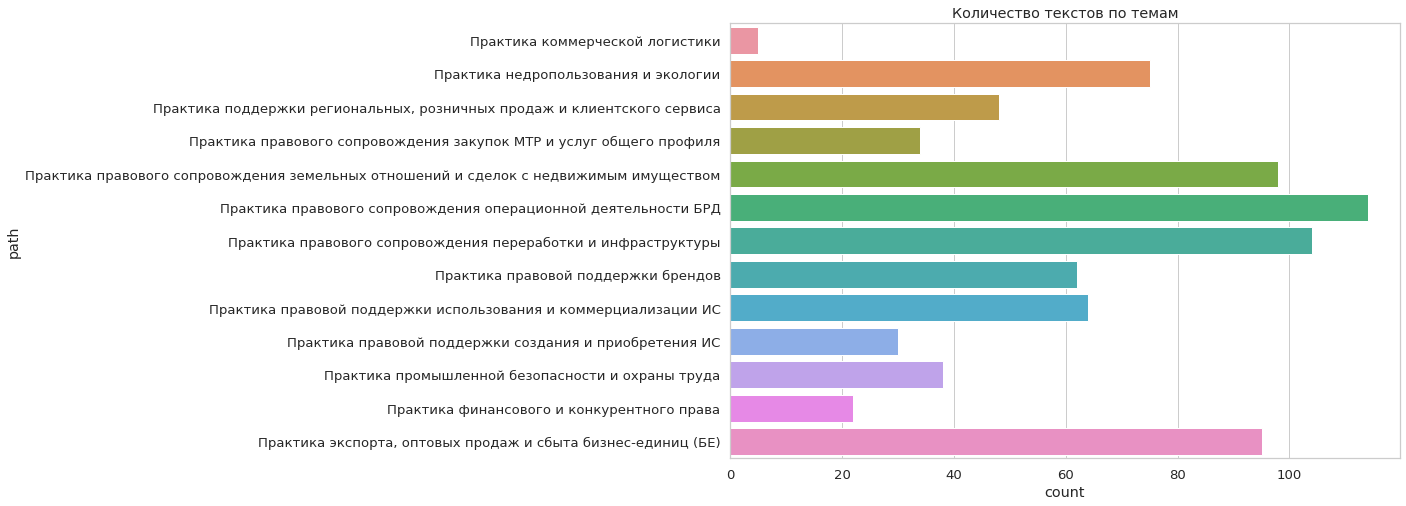

In [9]:
sns.countplot(data=df[training_columns], y='path')
plt.title("Количество текстов по темам")

In [10]:
df['text'][2]

'1.1. Перевозчик в порядке и на условиях, установленных настоящим Договором, обязуется за вознаграждение выполнить  комплекс услуг, связанных с перевозкой груза – топлива для реактивных двигателей ТС-1, соответствующее требованиям ГОСТ 10227 «Топлива для реактивных двигателей», ТР ТС 013/2011 «О требованиях к автомобильному и авиационному бензину и дизельному  судовому топливу, топливу для реактивных двигателей и мазуту» (далее – «Нефтепродукт») Клиента со склада ООО «Газпромнефть-Аэро Шереметьево» (далее – «Терминал-1») или со склада АО «Газпромнефть-Аэро» (далее – «Терминал-2»)   на склады филиалов АО «Газпромнефть-Аэро» и сторонних хранителей (далее – «Склад ГСМ»)._x000D_\n1.2. Оказание услуг должно осуществляться в соответствии с требованиями Правил дорожного движения, Федерального закона № 257-ФЗ от 08.11.2007 г. «Об автомобильных дорогах и о дорожной деятельности в Российской Федерации», _x000D_\n1.3.     Качество услуг должно соответствовать действующим нормативным документам РФ

In [11]:
# !pip install datasets
# !pip install -U scikit-learn
# !pip3 install torch

In [12]:
import datasets
categories = categories.tolist()
# datasets.ClassLabel(names=categories)
categories

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']

### stratified split

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df[training_columns], test_size=0.1,  stratify=df[['path']])

Text(0.5, 1.0, 'Количество текстов по темам в test set')

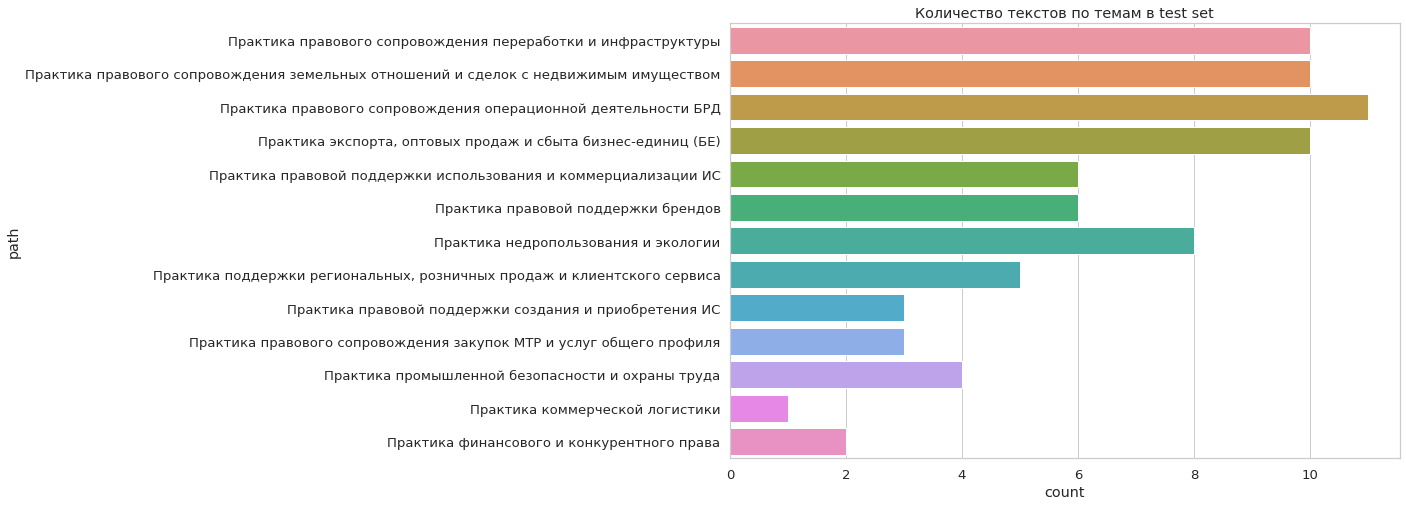

In [14]:
sns.countplot(data=test_df, y='path')
plt.title("Количество текстов по темам в test set")

In [15]:
import tensorflow as tf
from datasets import Dataset
categories_feature=datasets.ClassLabel(names=categories)
features = datasets.Features({'path': categories_feature})

# dataset = Dataset.from_pandas(df[training_columns])

trainset = Dataset.from_pandas(train_df)
testset = Dataset.from_pandas(test_df)

In [16]:
trainset

Dataset({
    features: ['path', 'text', '__index_level_0__'],
    num_rows: 710
})

In [17]:
testset

Dataset({
    features: ['path', 'text', '__index_level_0__'],
    num_rows: 79
})

In [18]:
trainset.features

{'path': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [19]:
def convert_to_class_label(row):
    row['path'] = categories_feature.str2int(row['path'])
    return row
# updated_dataset = dataset.map(convert_to_class_label)
trainset = trainset.map(convert_to_class_label)
testset = testset.map(convert_to_class_label)


  0%|          | 0/710 [00:00<?, ?ex/s]

  0%|          | 0/79 [00:00<?, ?ex/s]

### casting features

In [20]:
trainset.features

{'path': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [21]:
from datasets import ClassLabel, Value
new_features = trainset.features.copy()
new_features["path"] = ClassLabel(names=categories)

trainset = trainset.cast(new_features)
testnset = testset.cast(new_features)

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
trainset=trainset.shuffle(seed=42)
testset=testset.shuffle(seed=42)
trainset['path'][:5]

[2, 5, 12, 6, 12]

In [23]:
# work_dataset = updated_dataset.train_test_split(test_size=0.1)
# work_dataset

## Metric

In [24]:
from datasets import load_dataset, load_metric
# metric = load_metric('glue','mrpc')
metric = load_metric('glue','sst2')

pp.pprint(metric)

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

## Preprocessing data

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [26]:
tokenizer("""
2.2. Технические, экономические, научные и другие требования к результатам Услуг, а также краткое содержание и сроки оказания основных этапов Услуг, являющиеся предметом настоящего Договора, изложены в Приложении № 1 «Техническое задание», составляющем неотъемлемую часть настоящего Договора.
2.3. Результат Услуг используется Заказчиком при организации работ по охране окружающей среды, а также в качестве отчетных материалов для полномочных надзорных органов.

""")

{'input_ids': [1, 203, 22, 18, 22, 18, 12424, 20833, 16, 24248, 16, 24870, 289, 2316, 8013, 294, 16478, 615, 486, 954, 16, 376, 1196, 6501, 2564, 10217, 289, 15419, 36574, 10350, 44019, 615, 486, 954, 16, 25565, 3116, 18594, 11388, 20429, 264, 16, 12810, 929, 281, 26164, 370, 807, 3722, 514, 440, 32428, 33063, 12271, 766, 23293, 327, 31524, 499, 2205, 11388, 20429, 264, 18, 203, 22, 18, 23, 18, 40093, 615, 486, 954, 12785, 5229, 340, 8695, 530, 4503, 827, 341, 24584, 18455, 14013, 16, 376, 1196, 281, 3396, 6018, 474, 12059, 582, 5236, 6673, 35160, 474, 8503, 18, 203, 203, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [27]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)


In [28]:
pre_tokenizer_columns = set(trainset.features)

trainset = trainset.map(preprocess_function, batched=True)
testset = testset.map(preprocess_function, batched=True)

tokenizer_columns = list(set(trainset.features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['input_ids', 'attention_mask']


In [29]:
trainset.features["path"]

ClassLabel(num_classes=13, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки брендов', 'Практика правовой поддержки использования и коммерциализации ИС', 'Практика правовой поддержки создания и приобретения ИС', 'Практика промышленной безопасности и охраны труда', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)'], names_file=None, id=None)

In [30]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")


tf_train_dataset = trainset.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = testset.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

2021-12-17 01:28:35.939869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 01:28:35.943438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 01:28:35.944091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 01:28:35.945126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Fine-tuning the model

In [31]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

from pathlib import Path
saved_model_path=Path.cwd() / 'doc-classification'

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
num_labels = categories_feature.num_classes

if saved_model_path.exists():
    model = TFAutoModelForSequenceClassification.from_pretrained(str(saved_model_path), from_pt=False)
    print(f'loaded from: {str(saved_model_path)}')
else:
    model = TFAutoModelForSequenceClassification.from_pretrained(
        model_checkpoint, num_labels=num_labels, from_pt=True
    )

2021-12-17 01:28:37.259431: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /root/doc-classifier/doc-classification.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


loaded from: /root/doc-classifier/doc-classification


In [32]:
from transformers import create_optimizer

num_epochs = 6
batches_per_epoch = len(trainset) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer, loss=loss)

In [33]:
# if model exists load

In [34]:
metric_name='accuracy'
task = 'mrpc'

def compute_metrics(predictions, labels):
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


### Fit

In [35]:
from transformers.keras_callbacks import PushToHubCallback

model_name = model_checkpoint.split("/")[-1]

history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
    # callbacks=[callback],
)

Epoch 1/6
88/88 [==============================] - 49s 378ms/step - loss: 0.7615 - val_loss: 0.7261
Epoch 2/6
88/88 [==============================] - 30s 347ms/step - loss: 0.4147 - val_loss: 0.5692
Epoch 3/6
88/88 [==============================] - 31s 349ms/step - loss: 0.2428 - val_loss: 0.5398
Epoch 4/6
88/88 [==============================] - 31s 350ms/step - loss: 0.1311 - val_loss: 0.5964
Epoch 5/6
88/88 [==============================] - 31s 351ms/step - loss: 0.0744 - val_loss: 0.5720
Epoch 6/6
88/88 [==============================] - 31s 351ms/step - loss: 0.0546 - val_loss: 0.5777


In [36]:

history.history

{'loss': [0.7615222930908203,
  0.41472557187080383,
  0.24275927245616913,
  0.1311454176902771,
  0.0744367316365242,
  0.05458278954029083],
 'val_loss': [0.7260652184486389,
  0.5692099332809448,
  0.5397530794143677,
  0.5963888764381409,
  0.5720414519309998,
  0.5777046084403992]}

In [37]:
model.save_pretrained('doc-classification')

## Evaluate

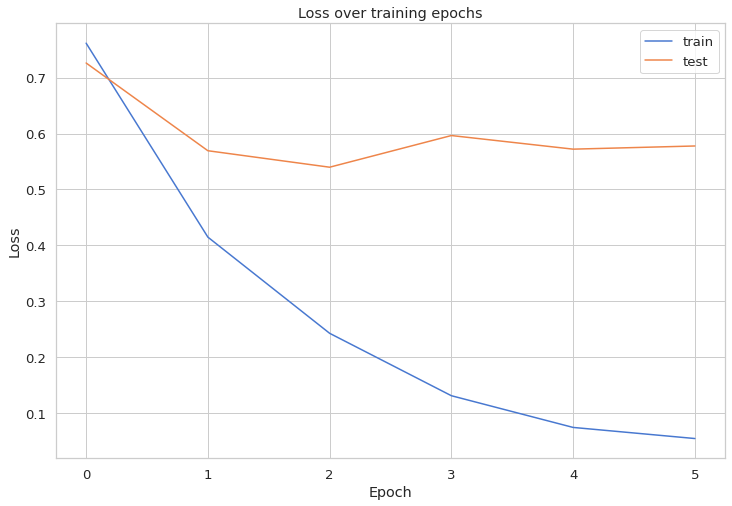

In [38]:
from matplotlib.ticker import MaxNLocator
#@title Loss over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [39]:
predictions = model.predict(tf_validation_dataset)["logits"]

In [40]:
import numpy as np
compute_metrics(predictions, np.array(testset["path"]))

{'accuracy': 0.8354430379746836}

In [41]:
#@title Accuracy
# _, train_acc = model.evaluate(data.train_x, data.train_y)
# _, test_acc = model.evaluate(data.test_x, data.test_y)

# print("train acc", train_acc)
# print("test acc", test_acc)

model.evaluate(tf_validation_dataset)

10/10 [==============================] - 1s 110ms/step - loss: 0.5777


0.5777046084403992

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = np.argmax(predictions, axis=1)
y_pred

array([ 7,  6,  5, 10,  1, 12,  6, 12,  4,  6,  6,  1, 10,  5,  8,  8,  7,
       12,  4,  7,  7,  8,  6,  6, 11, 12,  4,  4,  4,  4,  2,  3, 12,  4,
        9,  2,  1,  1,  8, 12,  4,  5, 12,  1,  2,  4,  9,  7,  1,  2,  6,
       12, 12,  8, 12,  2,  5,  8, 10,  6,  2,  1,  3, 12,  3,  6,  5, 12,
        5, 11,  6,  5,  5, 12, 10,  5,  8,  1,  5])

In [43]:
y = np.concatenate([y for x, y in tf_validation_dataset], axis=0)
y

array([ 7,  6,  5, 10,  1, 12,  6, 12,  4,  6,  6,  1, 10,  5,  8,  8,  7,
        3,  4,  7,  7,  8,  6,  6, 11, 12,  4,  4,  4,  4,  5,  1,  2,  4,
        9,  2,  1,  1,  9, 12,  4,  5,  2,  1,  3,  4,  9,  7,  5, 12,  6,
       12, 12,  8, 12,  7,  5,  8, 10,  6,  2,  1,  2, 12,  3,  6,  5,  0,
        5, 11,  6,  5,  5, 12, 10,  4,  8,  1,  5])

In [44]:
categories_feature.names

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']

In [45]:
categories_feature.int2str(12)

'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)'

In [46]:
# workaround for report
y_pred = np.concatenate((y_pred,[0]),axis=0)
y_pred

array([ 7,  6,  5, 10,  1, 12,  6, 12,  4,  6,  6,  1, 10,  5,  8,  8,  7,
       12,  4,  7,  7,  8,  6,  6, 11, 12,  4,  4,  4,  4,  2,  3, 12,  4,
        9,  2,  1,  1,  8, 12,  4,  5, 12,  1,  2,  4,  9,  7,  1,  2,  6,
       12, 12,  8, 12,  2,  5,  8, 10,  6,  2,  1,  3, 12,  3,  6,  5, 12,
        5, 11,  6,  5,  5, 12, 10,  5,  8,  1,  5,  0])

In [47]:
y = np.concatenate((y,[0]),axis=0)
y

array([ 7,  6,  5, 10,  1, 12,  6, 12,  4,  6,  6,  1, 10,  5,  8,  8,  7,
        3,  4,  7,  7,  8,  6,  6, 11, 12,  4,  4,  4,  4,  5,  1,  2,  4,
        9,  2,  1,  1,  9, 12,  4,  5,  2,  1,  3,  4,  9,  7,  5, 12,  6,
       12, 12,  8, 12,  7,  5,  8, 10,  6,  2,  1,  2, 12,  3,  6,  5,  0,
        5, 11,  6,  5,  5, 12, 10,  4,  8,  1,  5,  0])

In [48]:
#@title Classification report
print(classification_report(y, y_pred, target_names=categories_feature.names))

                                                                                       precision    recall  f1-score   support

                                                      Практика коммерческой логистики       1.00      0.50      0.67         2
                                                 Практика недропользования и экологии       0.88      0.88      0.88         8
              Практика поддержки региональных, розничных продаж и клиентского сервиса       0.33      0.40      0.36         5
                  Практика правового сопровождения закупок МТР и услуг общего профиля       0.33      0.33      0.33         3
Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом       1.00      0.90      0.95        10
                       Практика правового сопровождения операционной деятельности БРД       0.90      0.82      0.86        11
                        Практика правового сопровождения переработки и инфраструктуры       1.00      1.00    

In [49]:
cm = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(cm, index=categories_feature.names, columns=categories_feature.names)

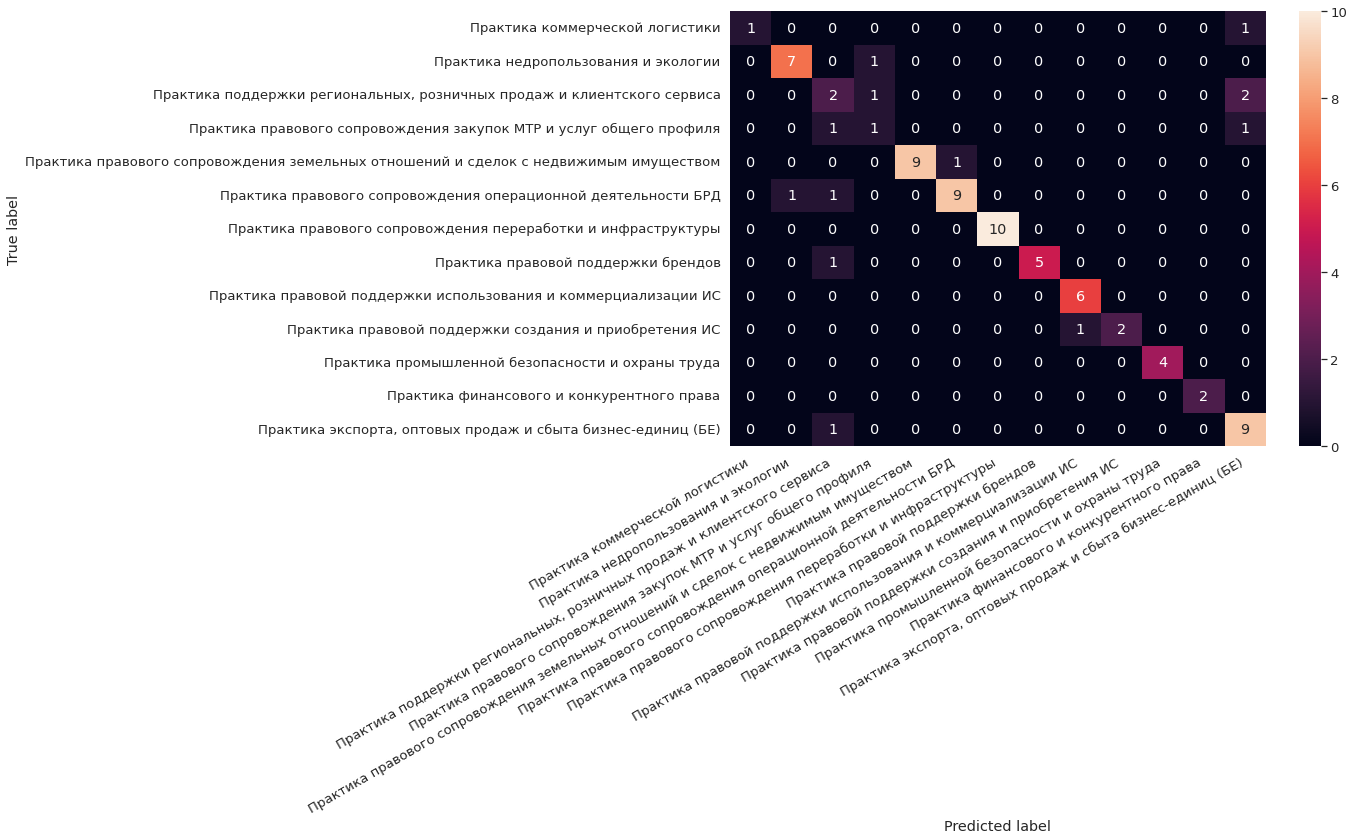

In [50]:
#@title Confusion matrix
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

## Predict

In [54]:
tf_validation_dataset

<PrefetchDataset shapes: ({attention_mask: (None, None), input_ids: (None, None)}, (None,)), types: ({attention_mask: tf.int64, input_ids: tf.int64}, tf.int64)>

In [37]:
text = '''
1.1. Заказчик поручает, а Исполнитель обязуется своими силами оказать Заказчику услуги по поиску, привлечению и отбору кандидатов, соответствующих требованиям Заказчика, на вакантные должности последнего на постоянную и временную работу на АЗС, более подробно описанные в Приложении № 1.
Услуги оказываются Исполнителем с __________________
1.2. По неисполненным денежным обязательствам договор действует до полного исполнения сторонами таких обязательств.
1.3. Отношения, возникающие по настоящему Договору, не являются трудовыми и регулируются исключительно гражданским законодательством. Исполнитель не включается в штат работников Заказчика, правила внутреннего трудового распорядка, утвержденные Заказчиком, на Исполнителя не распространяются. Исполнитель не получает прав, льгот и компенсаций, предусмотренных действующим трудовым законодательством для работников, выполняющих свою работу по трудовому договору (контракту). Заказчик не обязан осуществлять страхование Исполнителя от несчастного случая на производстве и профессиональных заболеваний.

'''
r = tokenizer(text, truncation=True, max_length=512)

In [38]:
r

{'input_ids': [1, 203, 21, 18, 21, 18, 5229, 340, 1445, 4935, 456, 16, 376, 37569, 540, 1986, 3238, 2924, 8296, 15236, 5229, 340, 15963, 12142, 341, 3475, 272, 16, 16113, 974, 289, 13116, 272, 18149, 16, 23478, 21846, 5229, 340, 5376, 16, 324, 18015, 892, 475, 9346, 7086, 324, 43824, 289, 642, 2705, 2852, 324, 448, 1229, 561, 16, 1027, 10921, 3265, 2592, 281, 26164, 370, 807, 331, 19846, 514, 18, 203, 1133, 486, 5088, 24689, 37569, 4152, 280, 225, 15680, 2414, 203, 21, 18, 22, 18, 945, 14664, 819, 268, 1760, 8221, 480, 20097, 338, 2986, 10123, 624, 11214, 16524, 36997, 2479, 20097, 18, 203, 21, 18, 23, 18, 1200, 19199, 16, 6764, 4275, 341, 28728, 20429, 272, 16, 332, 5291, 1566, 7972, 289, 15107, 33702, 6910, 2626, 1634, 35752, 18, 37569, 540, 332, 2617, 704, 281, 9644, 13095, 5229, 340, 5376, 16, 7879, 14437, 45505, 10821, 428, 16, 4707, 1209, 5229, 340, 8695, 16, 324, 37569, 1611, 332, 3894, 8891, 18, 37569, 540, 332, 10915, 720, 16, 28722, 289, 15907, 1971, 16, 49980, 43457, 1566, 3

In [39]:
predictions = model.predict([r['input_ids']])['logits']

In [40]:
predictions

array([[-0.73501086, -1.2939368 ,  4.1319013 ,  0.6204379 , -0.1843539 ,
        -1.0700302 , -1.2254825 ,  0.94197637, -1.2017342 , -1.3603083 ,
        -0.7224869 ,  0.7995952 ,  0.6095731 ]], dtype=float32)

In [41]:
predictions = np.argmax(predictions, axis=1)

In [42]:
predictions

array([2])

In [43]:
categories_feature.int2str(int(predictions[0]))

'Практика поддержки региональных, розничных продаж и клиентского сервиса'